In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from plot_utils import cblind_cmap

IMPORTANCE_PATH = Path().resolve().parent / "analysis/data/importance"

plt.style.use("style.mplstyle")

PHASES = ["liquid", "ice", "mixed", "drizzle", "liq_driz", "rain", "snow"]
letter_labels = [f"({letter})" for letter in "abcdefghijklmnopqrstuvwxyz"]

cmap = cblind_cmap.copy()
cmap["avg"] = "black"

phases = [
    "liquid", 
    "ice", 
    "mixed", 
    "drizzle", 
    "liq_driz", 
    "rain", 
    "snow",
]
models = {
    "cnn": "CNN",
    "mlp_balanced": "MLP",
    "rf_balanced": "RF",
}

In [2]:
FEATURE_NAME_MAP = {
    "mpl_backscatter": r"MPL $\beta$",
    "mpl_linear_depol_ratio": "MPL Dep",
    "reflectivity": "$Z_e$ (dBZ)",
    "mean_doppler_velocity": "MDV (m/s)",
    "spectral_width": "W (m/s)",
    "radar_linear_depolarization_ratio": "Radar Dep",
    "mwrret1liljclou_be_lwp": "LWP (g/$m^2$)",
    "temp": r"T ($\degree C$)",
}


def load_importances(_models: list[str] | None = None) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Loads phase importance files for each model and returns a new dataframe with
    columns: "feature", "acc", "importance", "model". Also does this for the
    phase-height files. Returns the combined phase importance dataframe and the combined
    phase-height importance dataframe."""
    _models = ["cnn", "mlp_balanced", "rf_balanced"] if _models is None else _models

    _p_i_dfs = []
    for _model in _models:
        df = pd.read_parquet(IMPORTANCE_PATH / f"{_model}_importance.parquet")
        df["model"] = _model
        df["feature"] = pd.Categorical(
            df["feature"].map(FEATURE_NAME_MAP),
            categories=FEATURE_NAME_MAP.values(),
            ordered=True,
        )
        df = df.sort_values("feature").rename(columns={"acc": "recall"})
        _p_i_dfs.append(df)
    p_i_df = pd.concat(_p_i_dfs)

    _p_h_i_dfs = []
    for _model in _models:
        df = pd.read_parquet(IMPORTANCE_PATH / f"{_model}_height_importance.parquet")
        df["model"] = _model
        df = df.rename(columns={"acc": "recall", "variable": "feature"})
        df["feature"] = pd.Categorical(
            df["feature"].map(FEATURE_NAME_MAP),
            categories=FEATURE_NAME_MAP.values(),
            ordered=True,
        )
        df = df.sort_values("feature")
        _p_h_i_dfs.append(df)
    p_h_i_df = pd.concat(_p_h_i_dfs)
    return p_i_df.reset_index(), p_h_i_df.reset_index()

df, height_df = load_importances()

# Add an "avg" model, which is the mean importance of the other models
_p_i_phase_feature_df = (
    df
    .groupby(["phase", "feature"])
    .agg(
        importance=pd.NamedAgg("importance", "mean"),
        recall=pd.NamedAgg("recall", "mean"),
    )
    .reset_index()
)
_p_i_phase_feature_df["model"] = "avg"
df = pd.concat([df, _p_i_phase_feature_df])

df

,phase,feature,recall,importance,model
0,drizzle,MPL $\beta$,0.818005,0.005625,cnn
1,avg,MPL $\beta$,0.816273,0.074564,cnn
2,snow,MPL $\beta$,0.936293,0.000769,cnn
3,liquid,MPL $\beta$,0.591496,0.273699,cnn
4,ice,MPL $\beta$,0.961774,0.017126,cnn
...,...,...,...,...,...
59,snow,MDV (m/s),0.659951,0.302613,avg
60,snow,W (m/s),0.783265,0.179298,avg
61,snow,Radar Dep,0.922326,0.040237,avg
62,snow,LWP (g/$m^2$),0.963852,-0.001288,avg


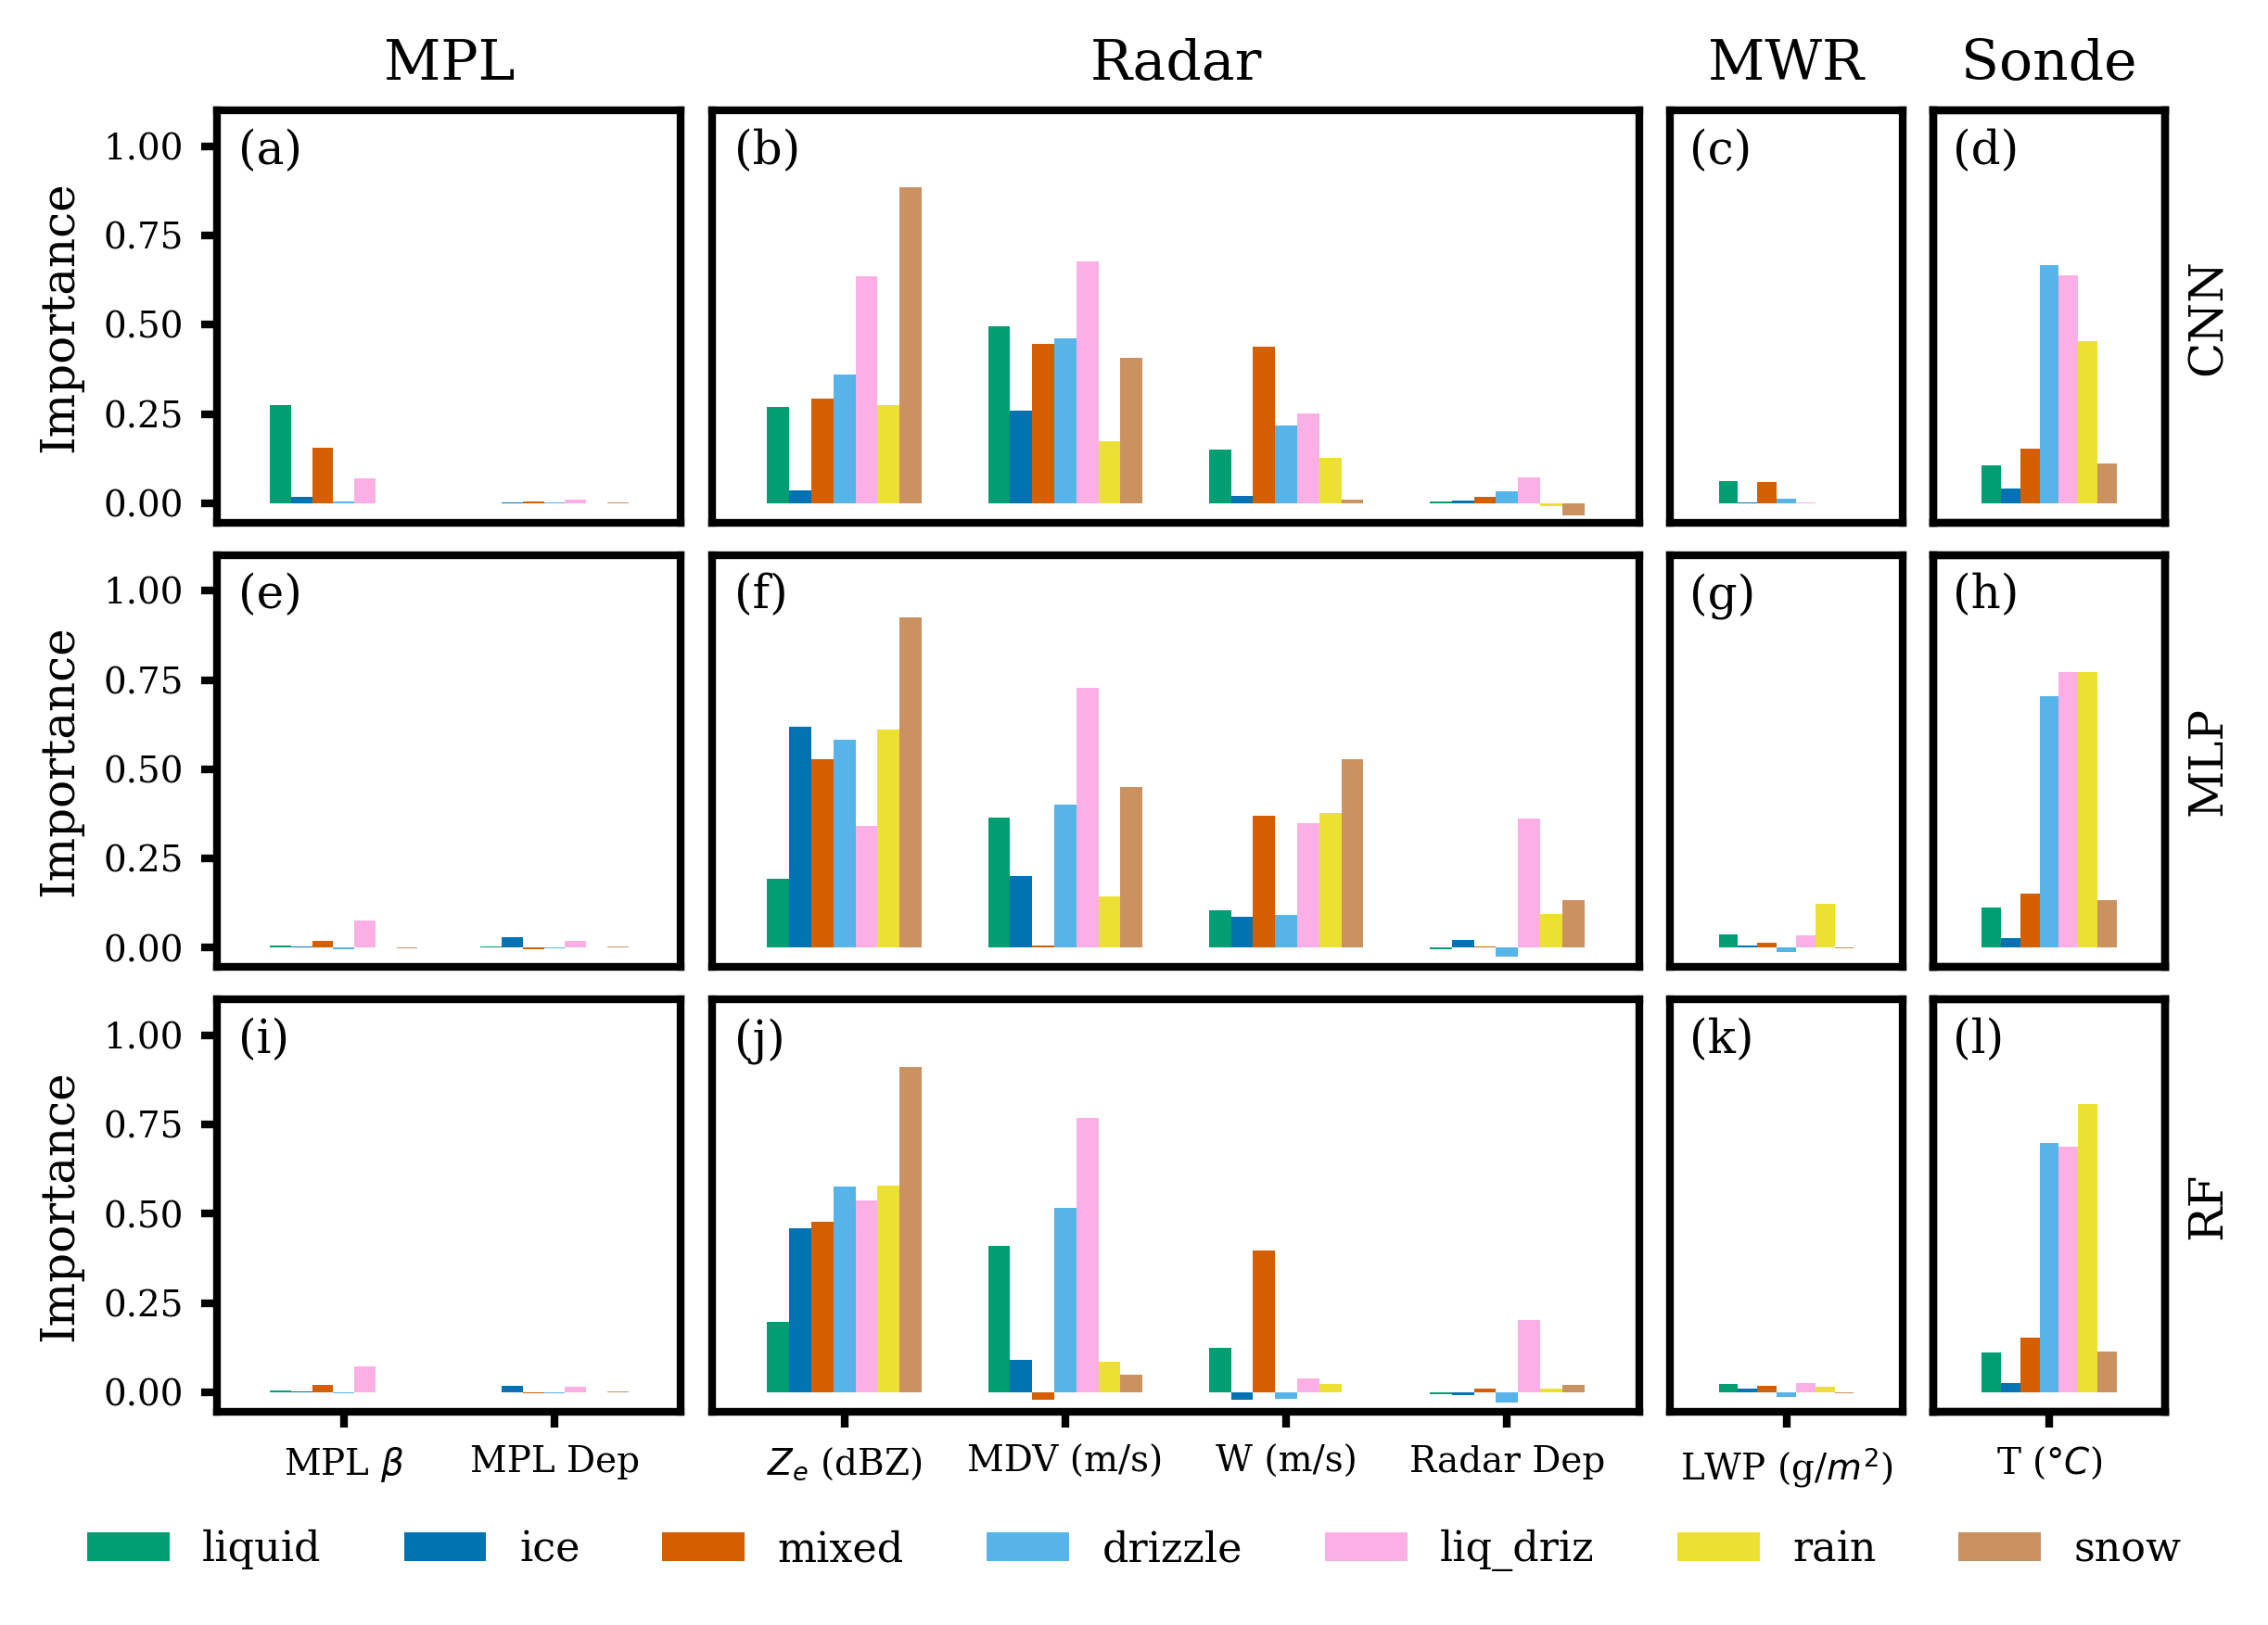

In [10]:
min_importance = min(-0.05, df["importance"].min() - 0.02)

groups = {
    "MPL": [r"MPL $\beta$", "MPL Dep"],
    "Radar": ["$Z_e$ (dBZ)", "MDV (m/s)", "W (m/s)", "Radar Dep"],
    "MWR": ["LWP (g/$m^2$)"],
    "Sonde": [r"T ($\degree C$)"],
}

fig, axs = plt.subplots(
    figsize=(6, 4),
    nrows=len(models),
    ncols=len(groups),
    # sharex=True,
    sharey=True,
    gridspec_kw={"width_ratios": [len(g) for g in groups.values()]},
    layout="constrained",
)

for i, (model, model_label) in enumerate(models.items()):

    # reshape importances to have index of feature and phase importances as columns. we
    # don't need 'avg' importance for this plot
    _model_data = df[(df["model"] == model) & (df["phase"] != "avg")]
    data = _model_data.pivot(index="feature", columns="phase", values="importance")
    data = data[phases]  # sort cols

    for j, (group_title, group_vars) in enumerate(groups.items()):
        ax = axs[i, j]
        group_data = data.loc[group_vars]
        group_data.plot.bar(ax=ax, width=0.7, color=cblind_cmap, legend=None)

        ax.set_ylim(min_importance, 1.1)
        ax.set_xlabel("")
        ax.set_ylabel("Importance")
        ax.xaxis.set_tick_params(rotation=0)

        if i == 0:
            ax.set_title(group_title)

        if i != len(models) - 1:
            ax.xaxis.set_ticklabels([])
            ax.xaxis.set_tick_params(bottom=False, top=False, labelbottom=False, which="both")

        if j != 0:
            # ax.yaxis.set_tick_params(direction="in")
            ax.yaxis.set_tick_params(bottom=False, top=False, labelbottom=False, which="both")

        if j == len(groups) - 1:
            y_twin = ax.twinx()
            ax.yaxis.set_tick_params(bottom=False, top=False, labelbottom=False, which="both")
            y_twin.set_ylabel(model_label)
            y_twin.set_yticks([], [])


        ax.text(
            x=-0.5,
            y=1.05,
            # x=0.05,
            # y=0.9,
            # transform=ax.transAxes,
            s=letter_labels[j + len(groups) * i],
            verticalalignment="top",
            horizontalalignment="left",
            # fontweight="bold",
            fontsize=9,
        )

handles, labels = axs[-1, -1].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=7,
    bbox_to_anchor=(0.5, -0.07),
    fontsize=8,
)

fig.savefig("figures/feature_importance.png")
plt.show()

In [26]:
df_avg = df[df["phase"] == "avg"].copy(deep=True)

instr_map = {
    r"MPL $\beta$": "MPL",
    "MPL Dep": "MPL",

    "$Z_e$ (dBZ)": "Radar",
    "MDV (m/s)": "Radar",
    "W (m/s)": "Radar",
    "Radar Dep": "Radar",

    "LWP (g/$m^2$)": "MWR",
    r"T ($\degree C$)": "Sonde",
}
df_avg["instrument"] = df_avg["feature"].map(instr_map)
df_avg = df_avg[df_avg["model"] != "avg"]
df_avg.pop("phase")
df_avg

,feature,recall,importance,model,instrument
1,MPL $\beta$,0.816273,0.074564,cnn,MPL
14,MPL Dep,0.887839,0.002998,cnn,MPL
22,$Z_e$ (dBZ),0.497675,0.393163,cnn,Radar
31,MDV (m/s),0.473303,0.417534,cnn,Radar
32,W (m/s),0.716624,0.174213,cnn,Radar
47,Radar Dep,0.877082,0.013755,cnn,Radar
54,LWP (g/$m^2$),0.871124,0.019713,cnn,MWR
56,T ($\degree C$),0.580441,0.310396,cnn,Sonde
65,MPL $\beta$,0.879262,0.014443,mlp_balanced,MPL
78,MPL Dep,0.886225,0.007480,mlp_balanced,MPL


/var/folders/5n/ycnfz3351hj0gy28x0pbgbhr0000gn/T/ipykernel_24471/2701518210.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='feature', y='importance', hue='instrument', data=df_avg[df_avg["model"] == "cnn"], ci=None)


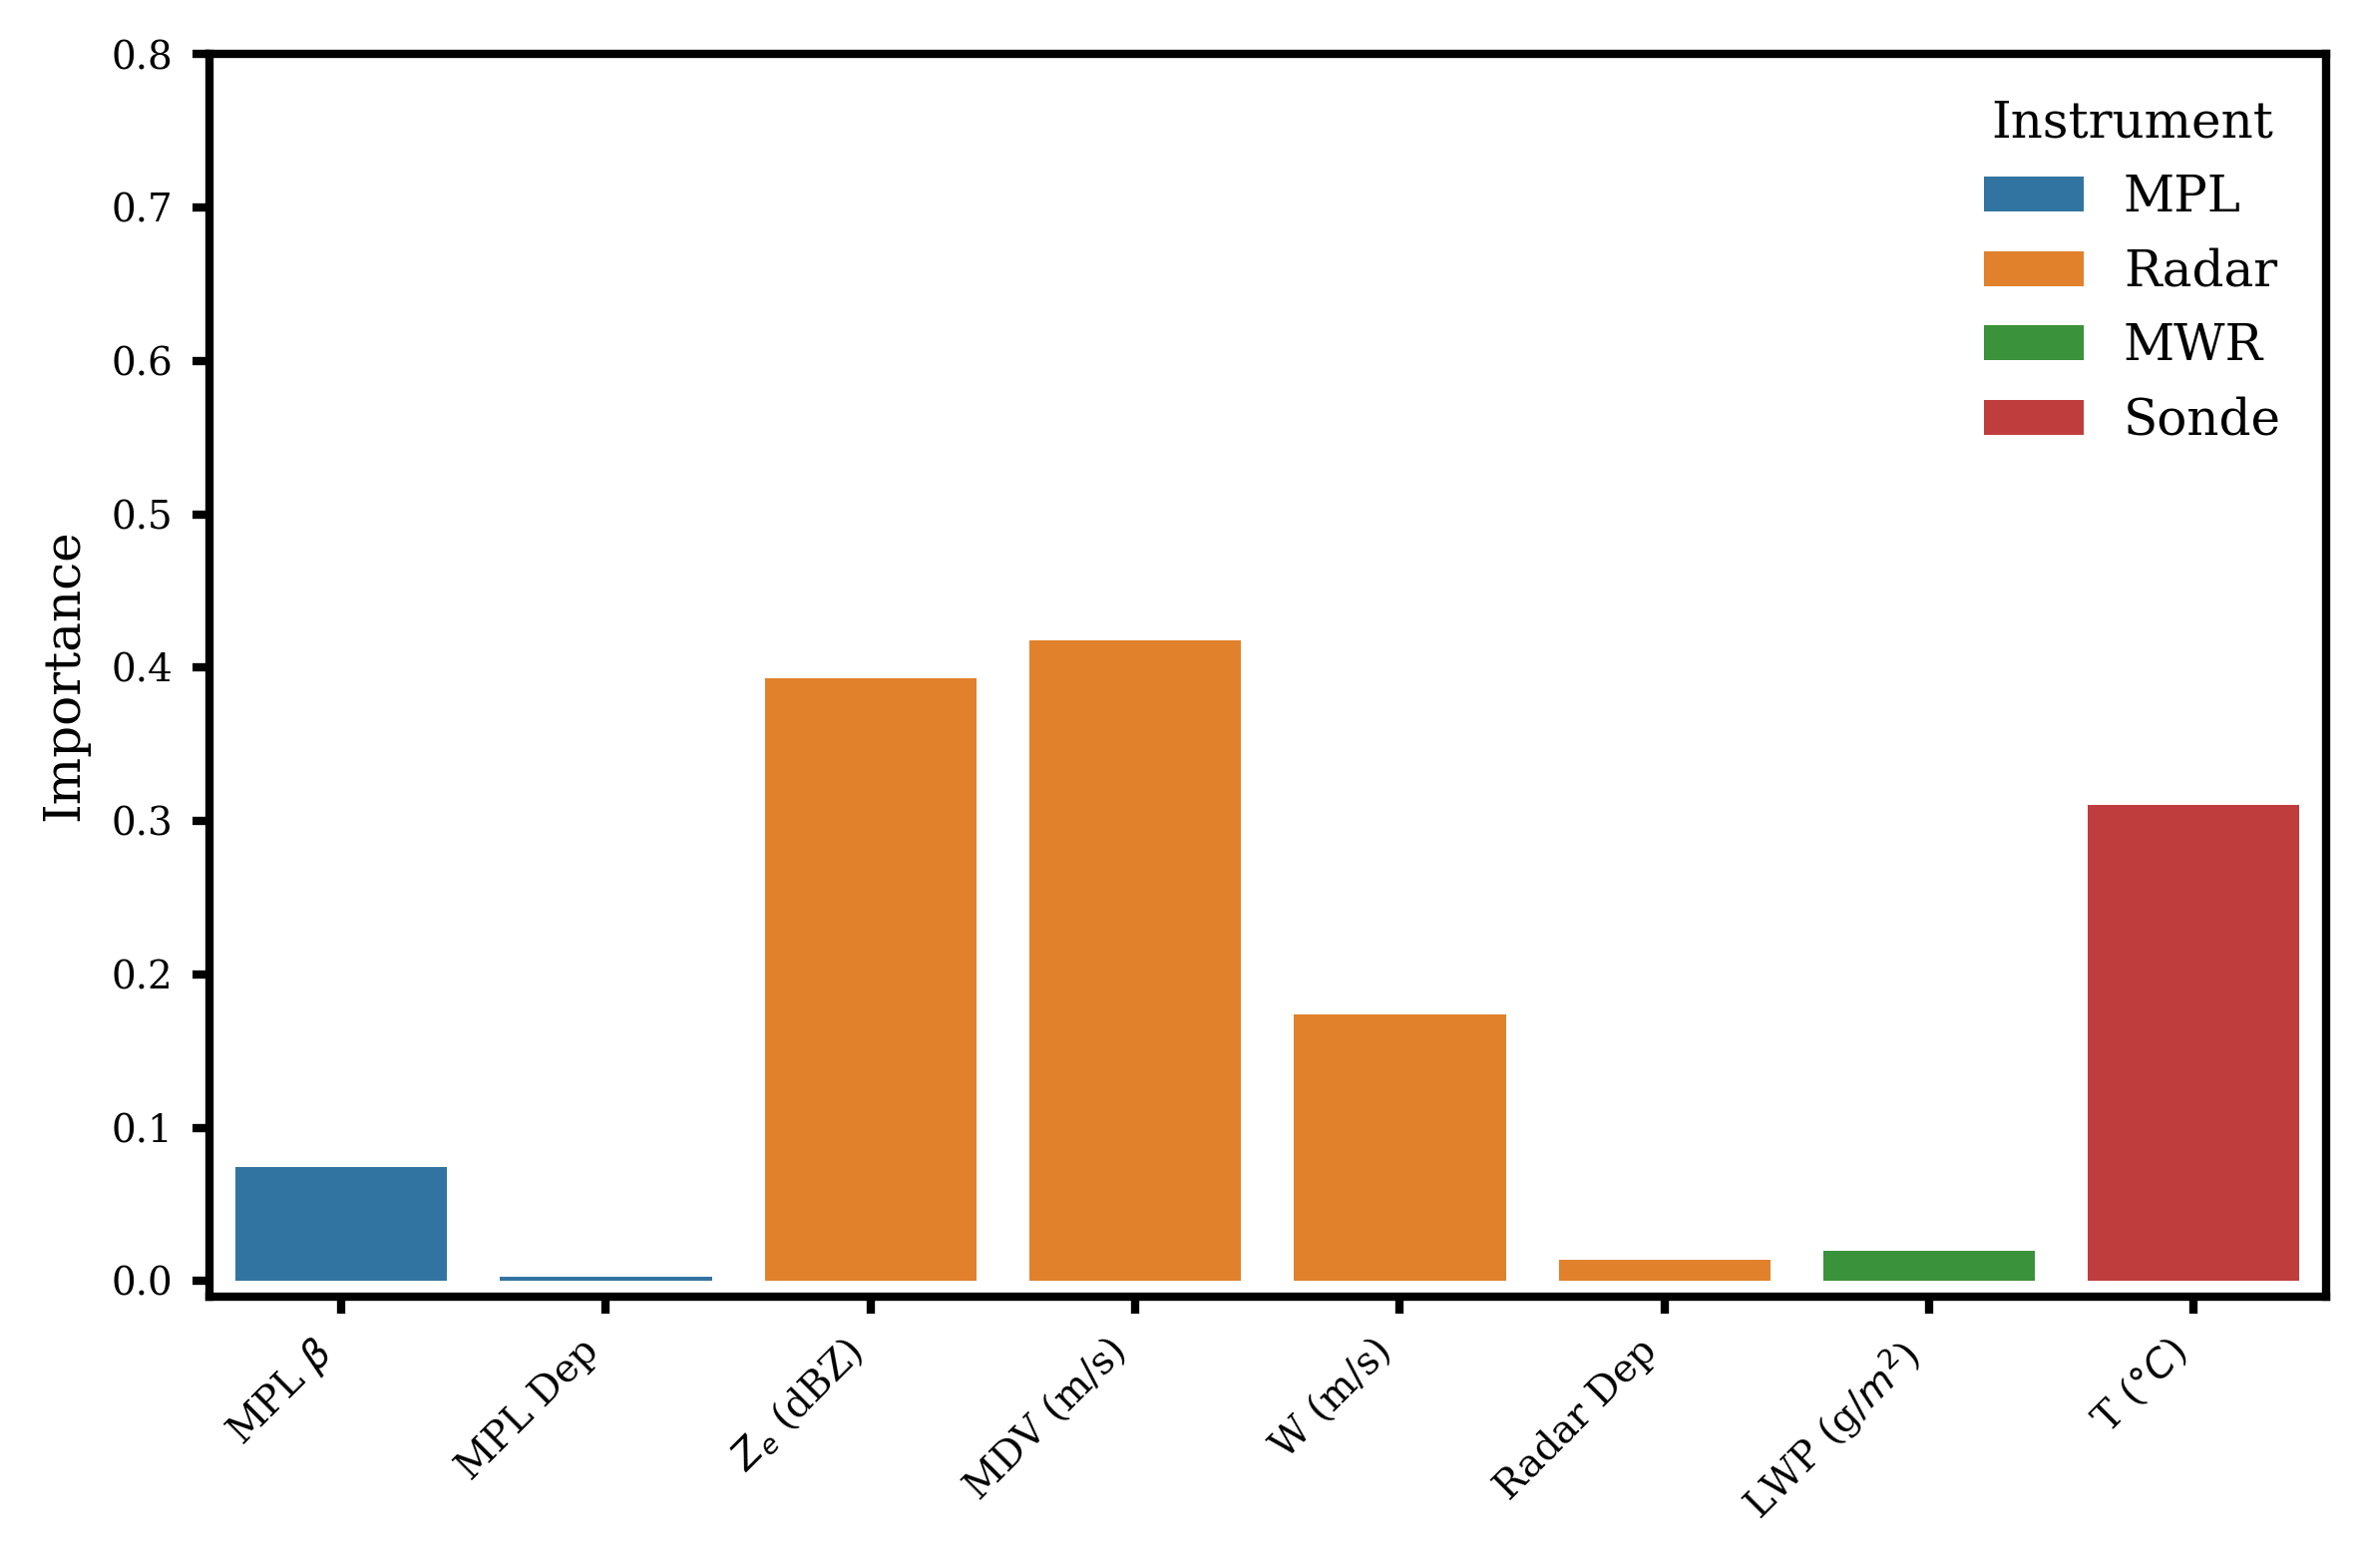

In [38]:
import seaborn as sns

plt.figure(figsize=(6,4))

# Use barplot with hue as the instrument
ax = sns.barplot(x='feature', y='importance', hue='instrument', data=df_avg[df_avg["model"] == "cnn"], ci=None)

# Adjust the plot
# ax.set_title('Feature Importance by Model and Instrument')
ax.set_ylabel('Importance')
ax.set_xlabel('')
ax.set_ylim(-0.01, 0.8)
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.legend(title='Instrument')
plt.tight_layout()
plt.show()

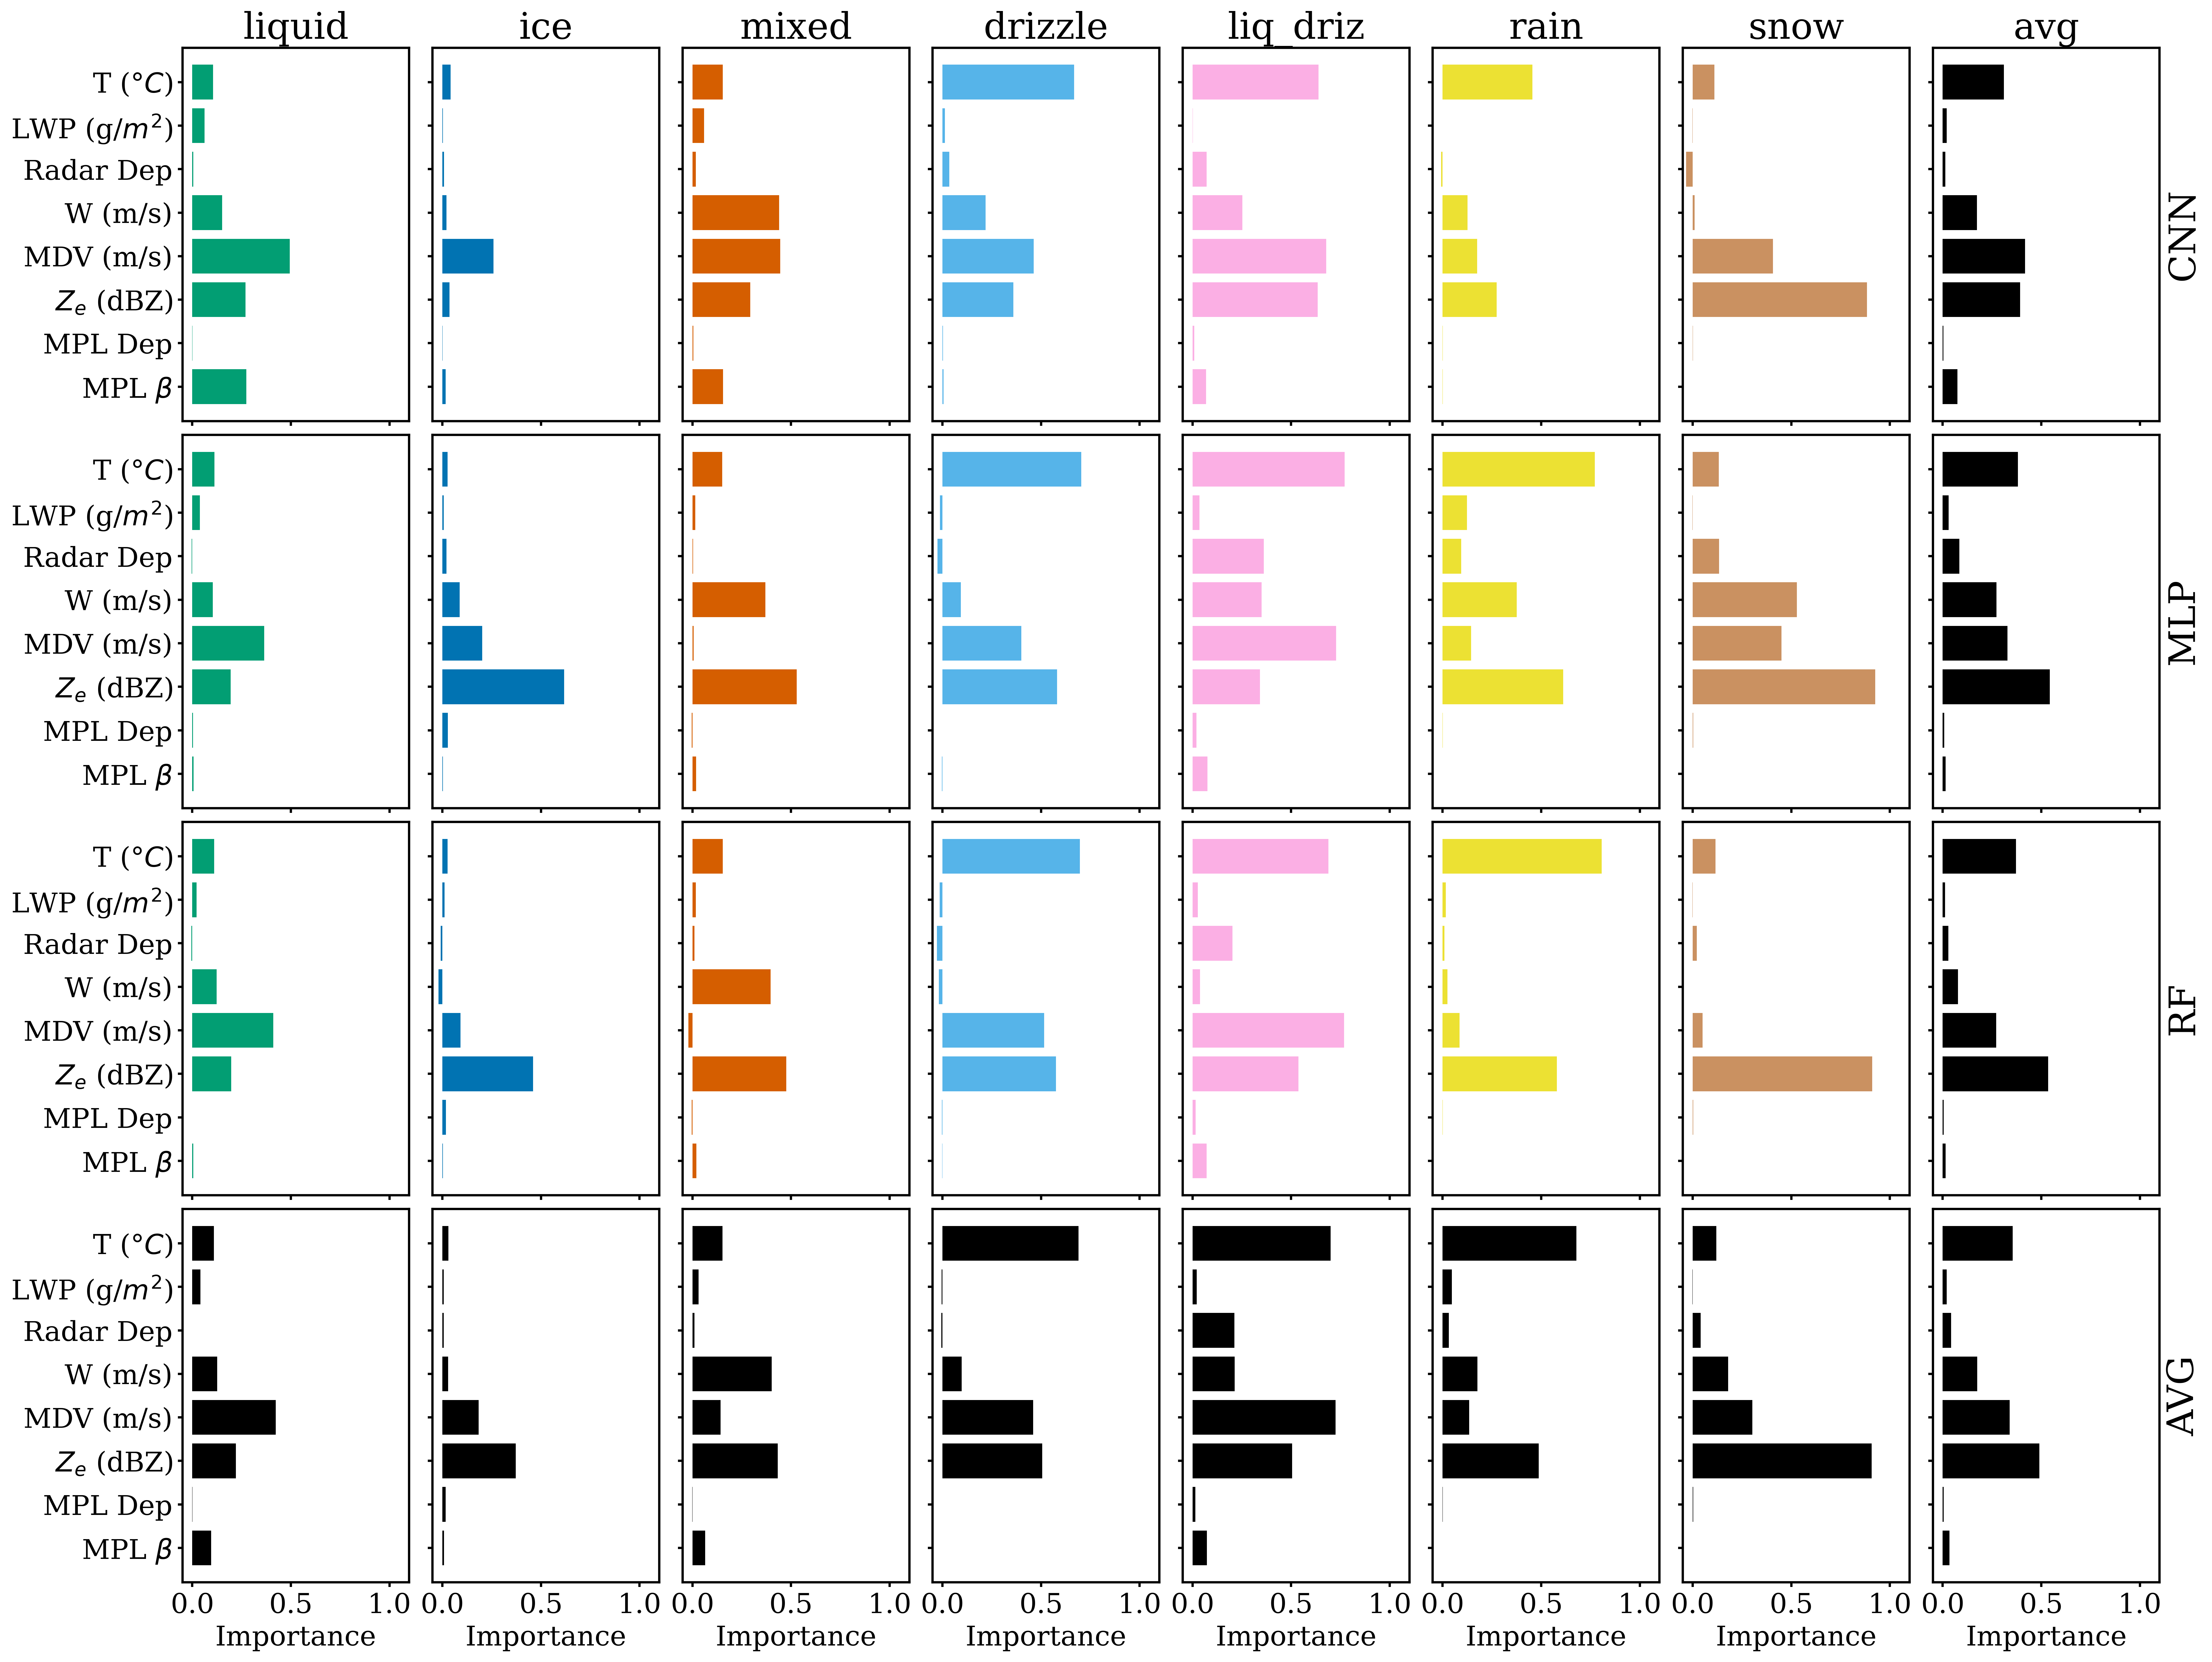

In [4]:
if "avg" not in phases:
    models["avg"] = "AVG"
    phases += ["avg"]


fig, axs = plt.subplots(len(models), len(phases), figsize=(20, 15), sharey=True, sharex=True, layout="constrained")


for i, model in enumerate(models):
    for j, phase in enumerate(phases):
        ax = axs[i, j]
        data_to_plot = df[(df['model'] == model) & (df['phase'] == phase)]
        if not data_to_plot.empty:
            ax.barh(data_to_plot['feature'], data_to_plot['importance'], color=cmap[phase] if model != "avg" else "black")
            ax.set_xlim([-0.05, 1.1])  # Adjust according to your data range
            ax.xaxis.set_ticks([0.0, 0.5, 1.0])
            ax.tick_params(axis='both', which='major', labelsize=18)

# Set Model Labels
j = len(phases) - 1
for i, model in enumerate(models.values()):
    ax = axs[i, j]
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(model, fontsize=24)

# Set Phase Labels
i = 0
for j, phase in enumerate(phases):
    ax = axs[i, j]
    ax.set_title(phase, fontsize=24)

# Set Importance X Label
i = len(models) - 1
for j in range(len(phases)):
    ax = axs[i, j]
    ax.set_xlabel("Importance", fontsize=18)

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.savefig("figures/all_importances.png")
plt.show()

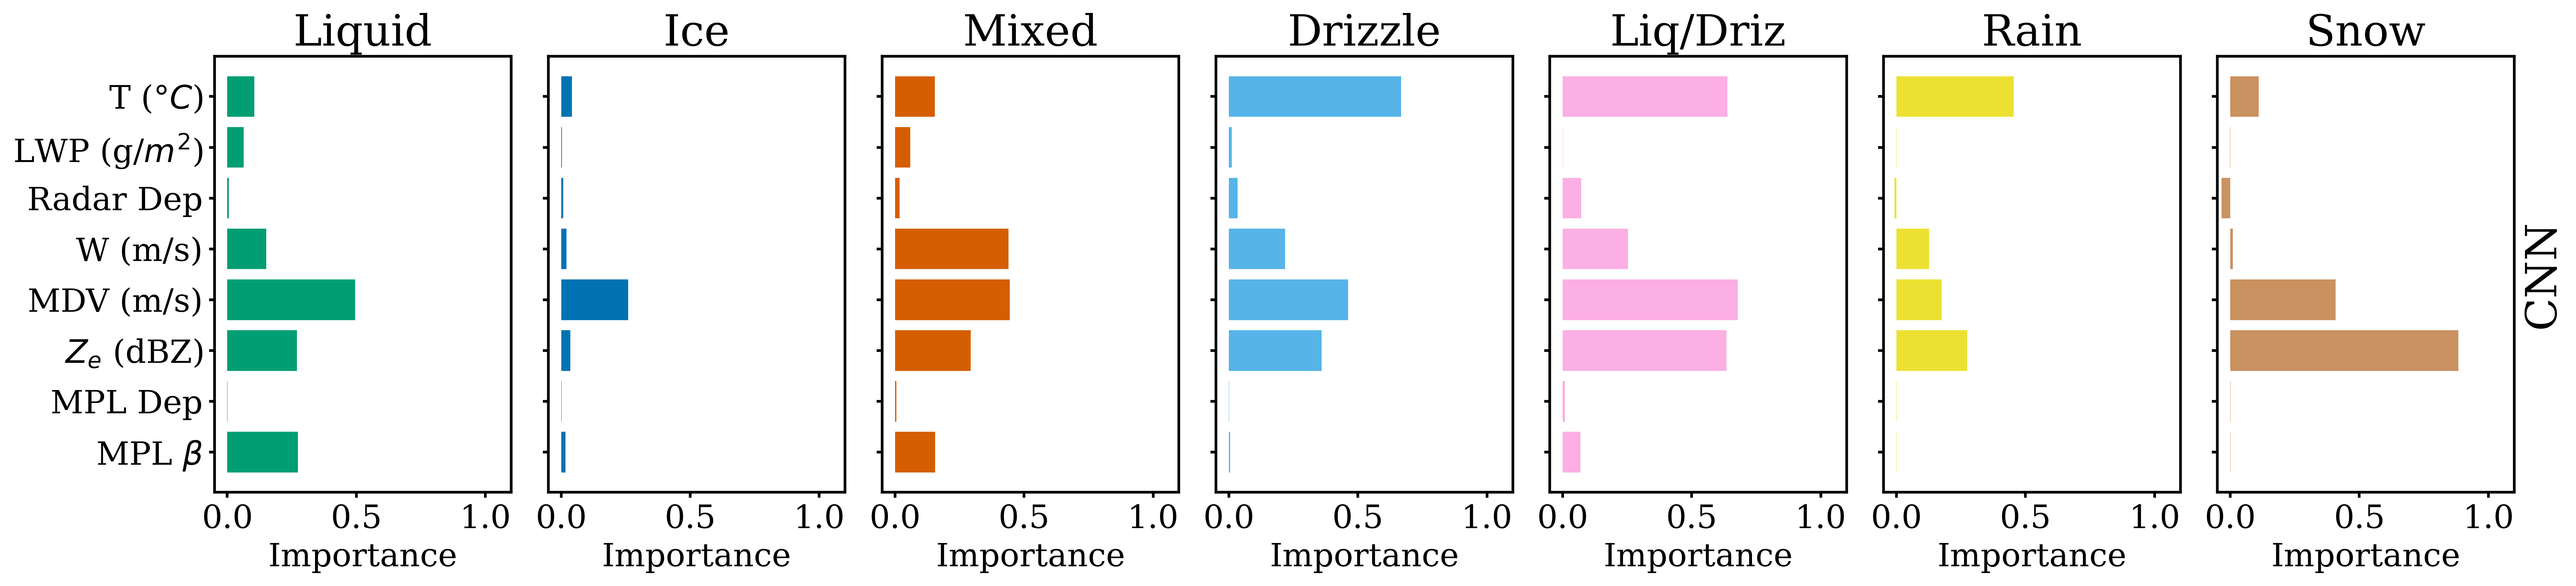

In [5]:
phases = {
    "liquid": "Liquid", 
    "ice": "Ice", 
    "mixed": "Mixed", 
    "drizzle": "Drizzle", 
    "liq_driz": "Liq/Driz", 
    "rain": "Rain", 
    "snow": "Snow",
    # "avg": "Avg",
}
model, model_label = "cnn", "CNN"


df = df.reset_index()

with plt.style.context("style.mplstyle"):
    fig, axs = plt.subplots(1, len(phases), figsize=(20, 5), sharey=True)
    for j, phase in enumerate(phases):
        ax = axs[j]
        data_to_plot = df[(df['model'] == model) & (df['phase'] == phase)]
        if not data_to_plot.empty:
            ax.barh(data_to_plot['feature'], data_to_plot['importance'], color=cmap[phase] if model != "avg" else "black")
            ax.set_xlim([-0.05, 1.1])
            ax.xaxis.set_ticks([0.0, 0.5, 1.0])
            ax.tick_params(axis='both', which='major', labelsize=18)

    # Set Model Labels
    ax = axs[-1]
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(model_label, fontsize=24)

    for j, phase in enumerate(phases.values()):
        ax = axs[j]
        ax.set_title(phase, fontsize=24)
        ax.set_xlabel("Importance", fontsize=18)


    # fig.suptitle('Feature Importance by Model and Phase', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    fig.savefig("figures/cnn_importances_v1.png")
    plt.show()

# Add the Dropout-CNN to Feature Importance Visuals

In [8]:
# #################################################################################### #
# Re-initialize global variables. Some of these were sloppily modified in the code
# blocks above (my bad).
PHASES = ["liquid", "ice", "mixed", "drizzle", "liq_driz", "rain", "snow"]
letter_labels = [f"({letter})" for letter in "abcdefghijklmnopqrstuvwxyz"]

cmap = cblind_cmap.copy()
cmap["avg"] = "black"

phases = [
    "liquid", 
    "ice", 
    "mixed", 
    "drizzle", 
    "liq_driz", 
    "rain", 
    "snow",
]
models = {
    "cnn": "CNN",
    "cnn_dropout": "CNN (2D Dropout)",
    "mlp_balanced": "MLP",
    "rf_balanced": "RF",
}

# #################################################################################### #
# Load datasets
df, height_df = load_importances(_models=["cnn", "cnn_dropout", "mlp_balanced", "rf_balanced"])

# Add an "avg" model, which is the mean importance of the other models
_p_i_phase_feature_df = (
    df
    .groupby(["phase", "feature"])
    .agg(
        importance=pd.NamedAgg("importance", "mean"),
        recall=pd.NamedAgg("recall", "mean"),
    )
    .reset_index()
)
_p_i_phase_feature_df["model"] = "avg"
df = pd.concat([df, _p_i_phase_feature_df])

df

,phase,feature,recall,importance,model
0,drizzle,MPL $\beta$,0.818005,0.005625,cnn
1,avg,MPL $\beta$,0.816273,0.074564,cnn
2,snow,MPL $\beta$,0.936293,0.000769,cnn
3,liquid,MPL $\beta$,0.591496,0.273699,cnn
4,ice,MPL $\beta$,0.961774,0.017126,cnn
...,...,...,...,...,...
59,snow,MDV (m/s),0.586122,0.357649,avg
60,snow,W (m/s),0.788156,0.155614,avg
61,snow,Radar Dep,0.902544,0.041226,avg
62,snow,LWP (g/$m^2$),0.945141,-0.001370,avg


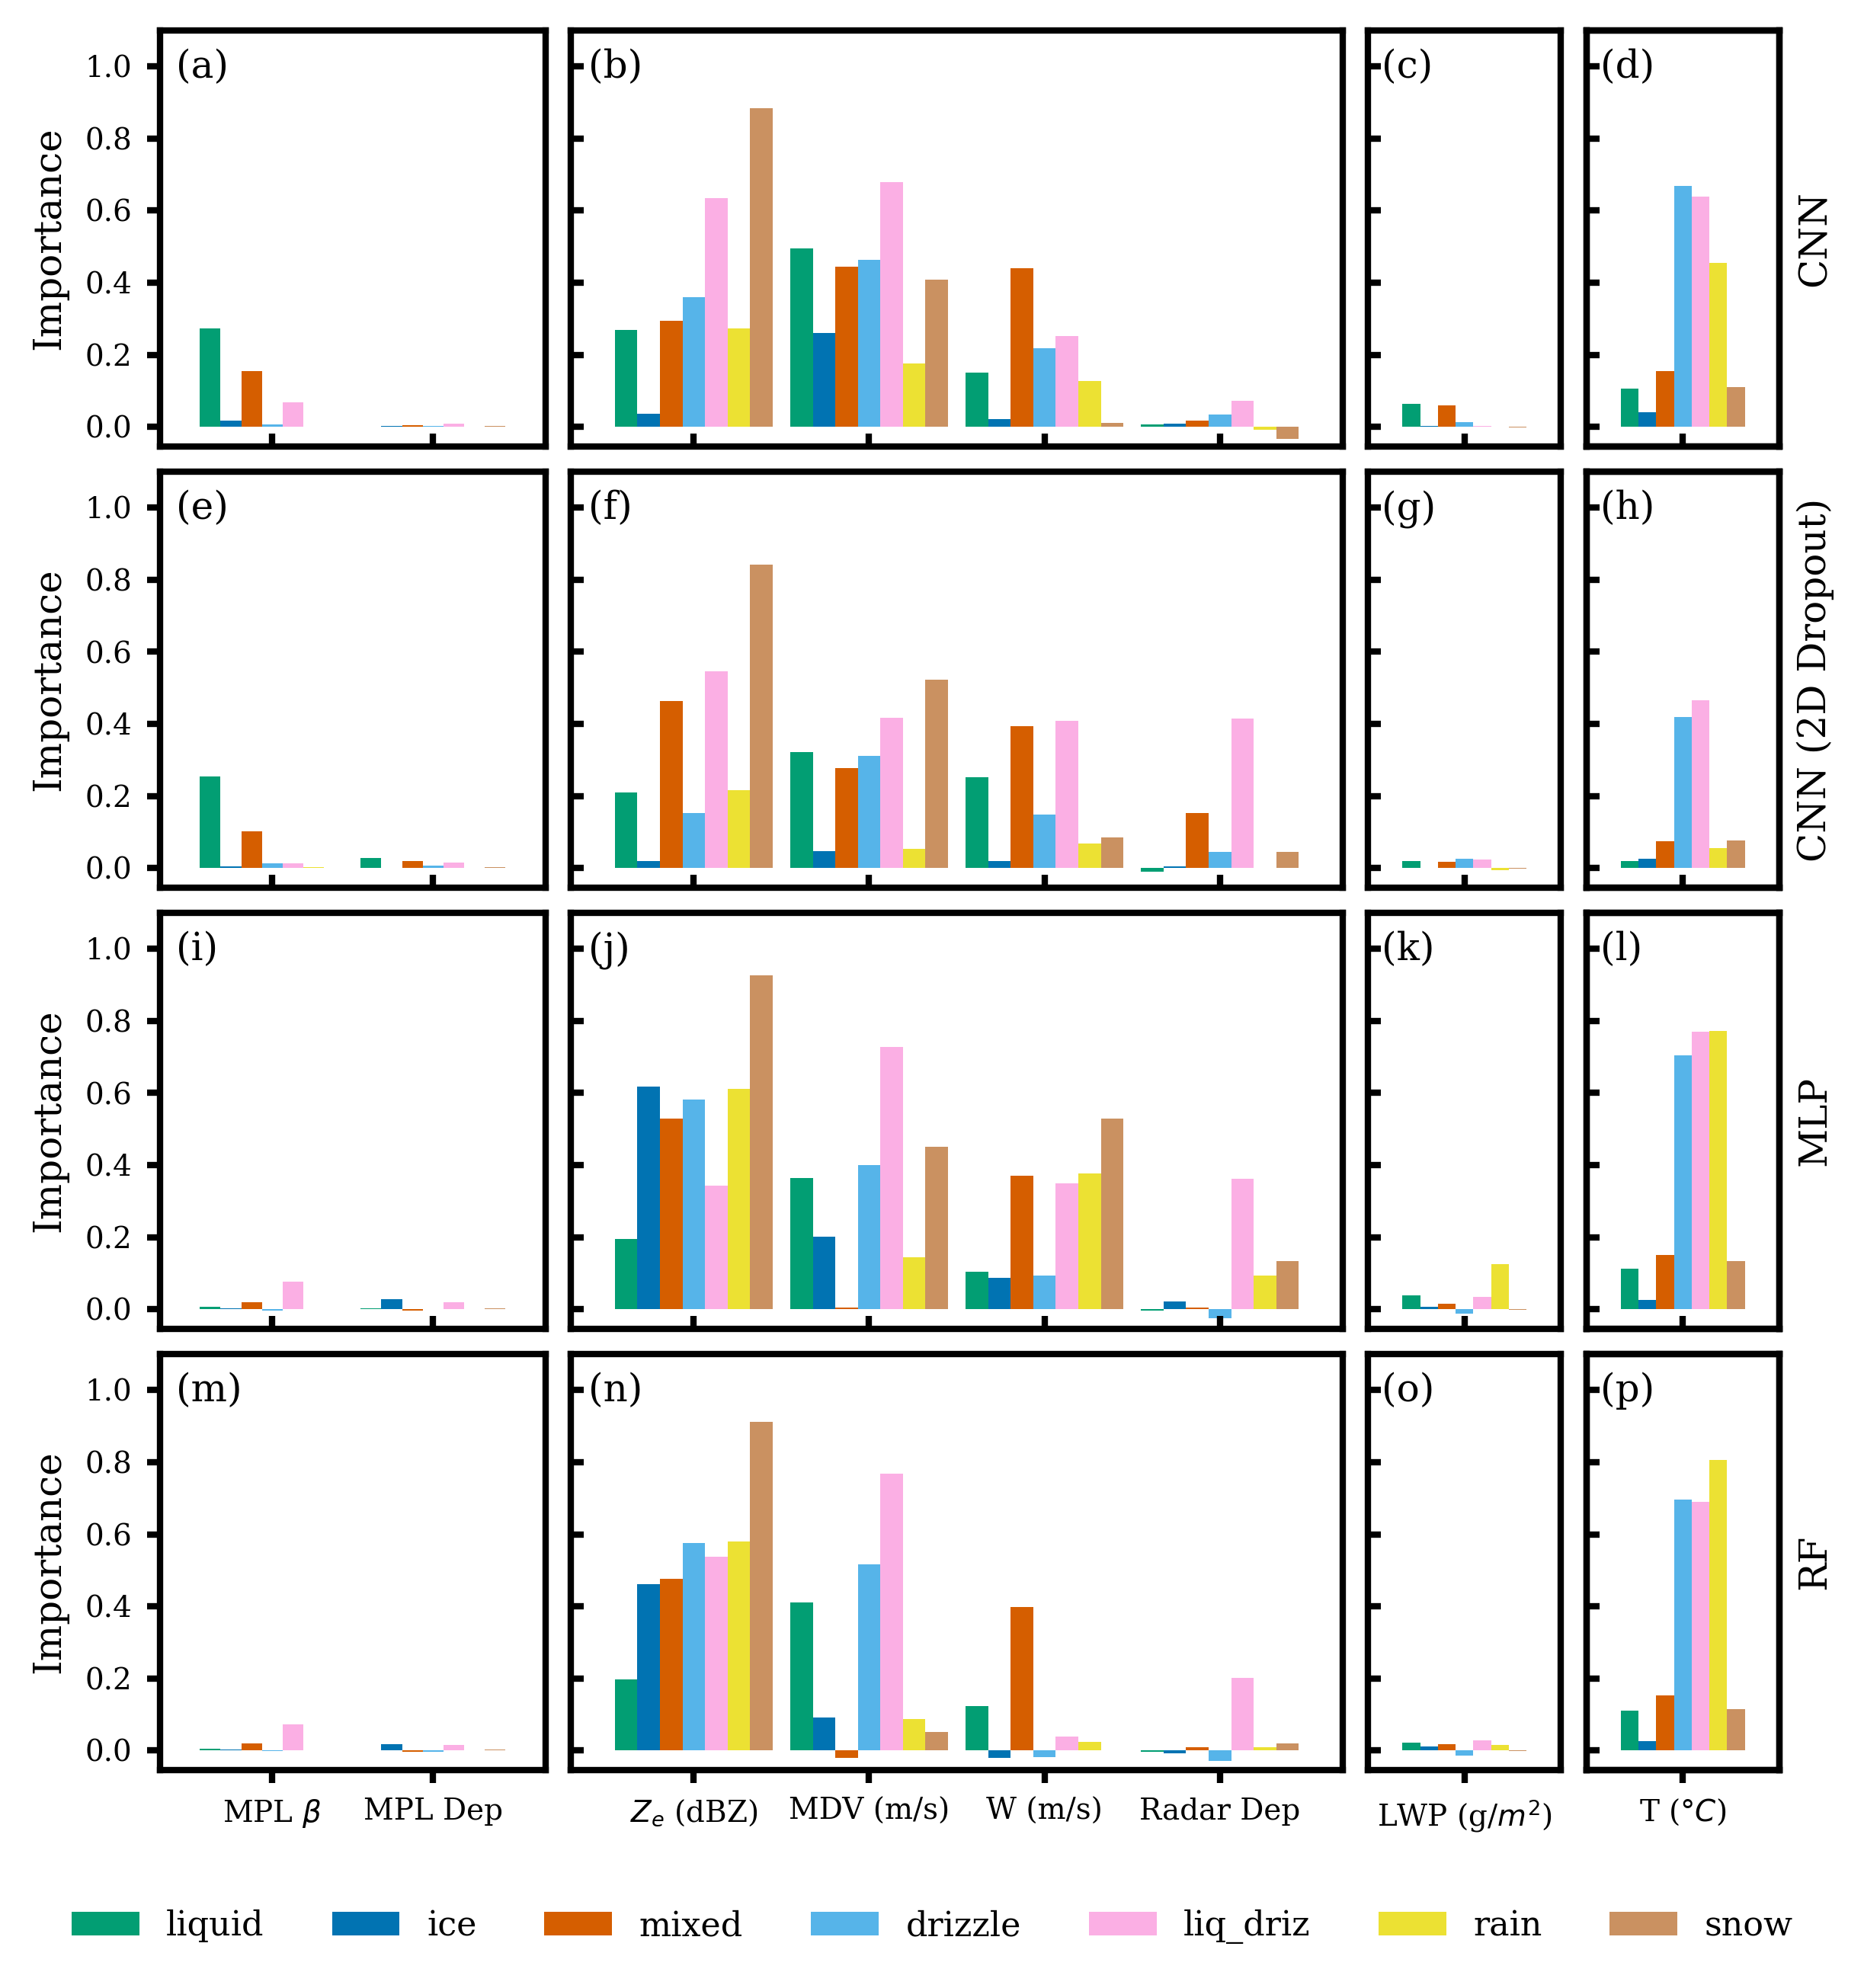

In [10]:
min_importance = min(-0.05, df["importance"].min() - 0.02)

groups = {
    "MPL": [r"MPL $\beta$", "MPL Dep"],
    "Radar": ["$Z_e$ (dBZ)", "MDV (m/s)", "W (m/s)", "Radar Dep"],
    "LWP": ["LWP (g/$m^2$)"],
    "T": [r"T ($\degree C$)"],
}

fig, axs = plt.subplots(
    figsize=(6, 6),
    nrows=len(models),
    ncols=len(groups),
    # sharex=True,
    sharey=True,
    gridspec_kw={"width_ratios": [len(g) for g in groups.values()]},
    layout="constrained",
)

for i, (model, model_label) in enumerate(models.items()):

    # reshape importances to have index of feature and phase importances as columns. we
    # don't need 'avg' importance for this plot
    _model_data = df[(df["model"] == model) & (df["phase"] != "avg")]
    data = _model_data.pivot(index="feature", columns="phase", values="importance")
    data = data[phases]  # sort cols

    for j, (group_title, group_vars) in enumerate(groups.items()):
        ax = axs[i, j]
        group_data = data.loc[group_vars]
        group_data.plot.bar(ax=ax, width=0.9, color=cblind_cmap, legend=None)
        ax.set_ylim(min_importance, 1.1)
        ax.set_xlabel("")
        ax.set_ylabel("Importance")
        ax.xaxis.set_tick_params(rotation=0)

        # if i == 0:
        #     ax.set_title(group_title)

        if i != len(models) - 1:
            ax.xaxis.set_ticklabels([])
            ax.xaxis.set_tick_params(direction="in")

        if j != 0:
            ax.yaxis.set_tick_params(direction="in")

        if j == len(groups) - 1:
            y_twin = ax.twinx()
            y_twin.set_ylabel(model_label)
            y_twin.set_yticks([], [])

        ax.text(
            x=-0.6,
            y=1.05,
            # x=0.05,
            # y=0.9,
            # transform=ax.transAxes,
            s=letter_labels[j + len(groups) * i],
            verticalalignment="top",
            horizontalalignment="left",
            # fontweight="bold",
            fontsize=9,
        )

handles, labels = axs[-1, -1].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=7,
    bbox_to_anchor=(0.5, -0.07),
    fontsize=8,
)

fig.savefig("figures/feature_importance_with_dropout.png")
plt.show()

In [12]:
if "avg" not in phases:
    models["avg"] = "AVG"
    phases += ["avg"]


fig, axs = plt.subplots(len(models), len(phases), figsize=(20, 20), sharey=True, sharex=True, layout="constrained")


for i, model in enumerate(models):
    for j, phase in enumerate(phases):
        ax = axs[i, j]
        data_to_plot = df[(df['model'] == model) & (df['phase'] == phase)]
        if not data_to_plot.empty:
            ax.barh(data_to_plot['feature'], data_to_plot['importance'], color=cmap[phase] if model != "avg" else "black")
            ax.set_xlim([-0.05, 1.1])  # Adjust according to your data range
            ax.xaxis.set_ticks([0.0, 0.5, 1.0])
            ax.tick_params(axis='both', which='major', labelsize=18)

# Set Model Labels
j = len(phases) - 1
for i, model in enumerate(models.values()):
    ax = axs[i, j]
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(model, fontsize=24)

# Set Phase Labels
i = 0
for j, phase in enumerate(phases):
    ax = axs[i, j]
    ax.set_title(phase, fontsize=24)

# Set Importance X Label
i = len(models) - 1
for j in range(len(phases)):
    ax = axs[i, j]
    ax.set_xlabel("Importance", fontsize=18)

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.savefig("figures/all_importances_with_dropout.png")
plt.show()

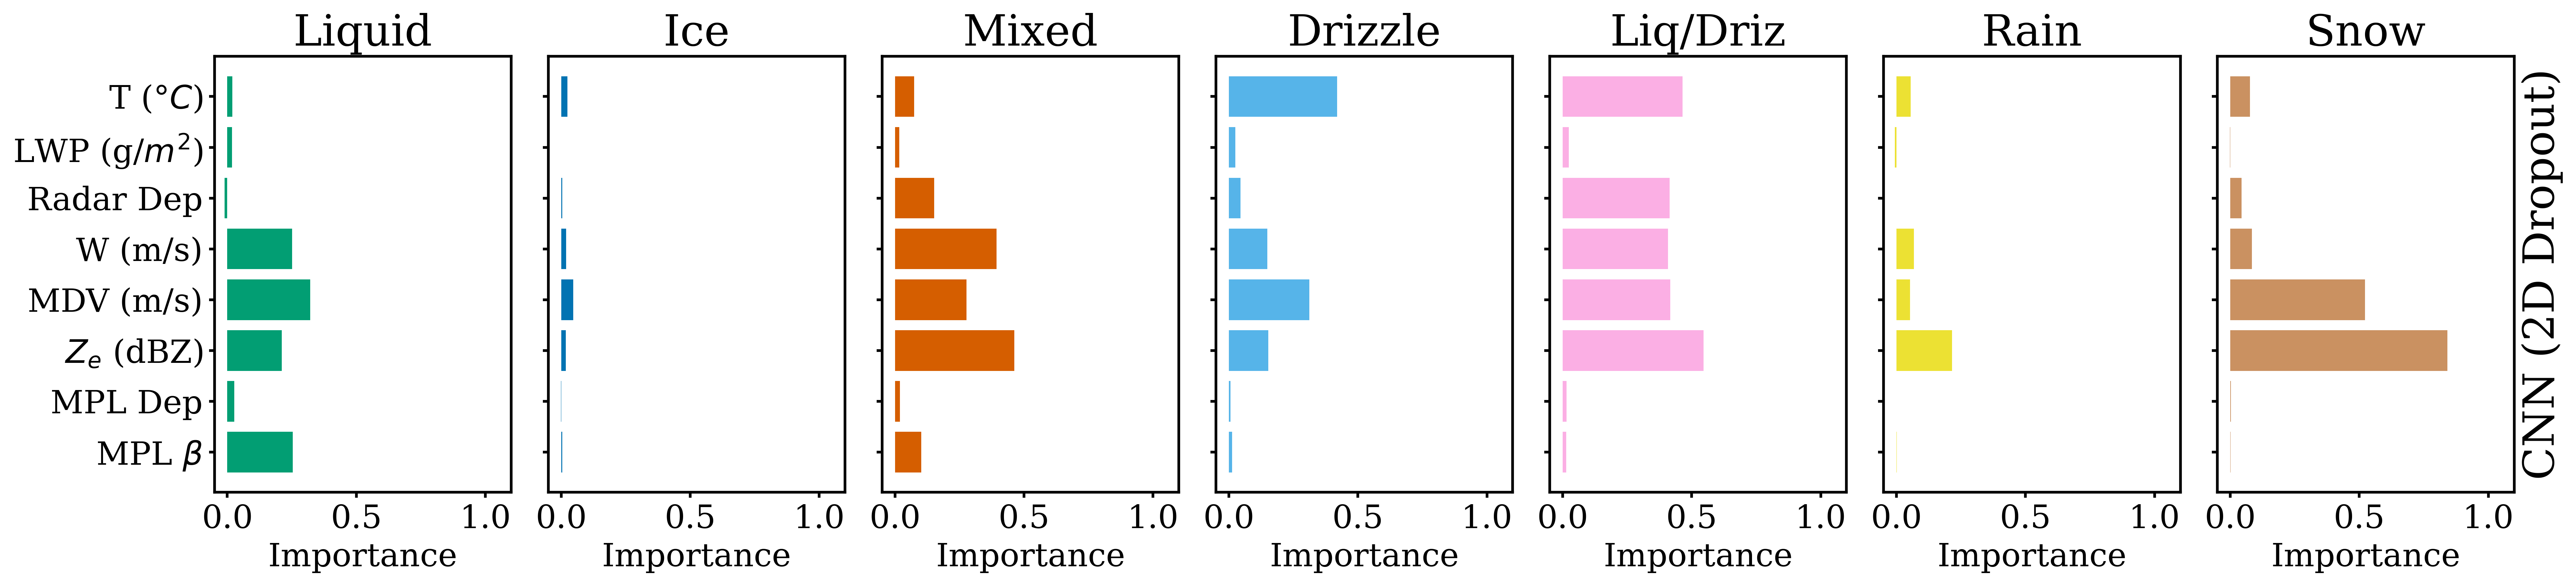

In [13]:
phases = {
    "liquid": "Liquid", 
    "ice": "Ice", 
    "mixed": "Mixed", 
    "drizzle": "Drizzle", 
    "liq_driz": "Liq/Driz", 
    "rain": "Rain", 
    "snow": "Snow",
    # "avg": "Avg",
}
model, model_label = "cnn_dropout", "CNN (2D Dropout)"


df = df.reset_index()

with plt.style.context("style.mplstyle"):
    fig, axs = plt.subplots(1, len(phases), figsize=(20, 5), sharey=True)
    for j, phase in enumerate(phases):
        ax = axs[j]
        data_to_plot = df[(df['model'] == model) & (df['phase'] == phase)]
        if not data_to_plot.empty:
            ax.barh(data_to_plot['feature'], data_to_plot['importance'], color=cmap[phase] if model != "avg" else "black")
            ax.set_xlim([-0.05, 1.1])
            ax.xaxis.set_ticks([0.0, 0.5, 1.0])
            ax.tick_params(axis='both', which='major', labelsize=18)

    # Set Model Labels
    ax = axs[-1]
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(model_label, fontsize=24)

    for j, phase in enumerate(phases.values()):
        ax = axs[j]
        ax.set_title(phase, fontsize=24)
        ax.set_xlabel("Importance", fontsize=18)


    # fig.suptitle('Feature Importance by Model and Phase', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.savefig("figures/cnn_dropout_importances_v1.png")
plt.show()